In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import signal
from scipy.io.idl import readsav
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import io
import cmocean
from bs4 import BeautifulSoup
import urllib.request
from io import StringIO, BytesIO
from zipfile import ZipFile
import tqdm
import seaborn as sn
import re

## get SSP emissions
from tools.RCMIP import *

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

%load_ext line_profiler
%load_ext memory_profiler

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
../tools/RCMIP.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  GIR_to_RCMIP_map.loc[RCMIP_to_GIR_map_concs.values(),'RCMIP_concs_unit'] = RCMIP_concs.loc[('World','ssp245')].reindex(RCMIP_to_GIR_map_concs.keys()).loc[:,'Unit'].values#.loc[('World','ssp245',RCMIP_to_GIR_map_concs.keys()),'Unit'].values


In [2]:
## RCMIP SSP emissions:
scenarios = ['ssp'+x for x in ['119','245','585','370']]#['ssp'+x for x in ['119','126','245','370','370-lowNTCF-aerchemmip','370-lowNTCF-gidden','434','460','534-over','585']]
ssp_emms = pd.concat([RCMIP_to_GIR_input_emms(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate()
ssp_emms = ssp_emms.loc[1750:2150] - ssp_emms.loc[1750]
ssp_forc = pd.concat([get_RCMIP_forc(x) for x in scenarios],keys=['esm-'+x+'-allGHG' for x in scenarios],axis=1).interpolate().loc[1750:2150]

## switch in GCP co2 emissions up to start of SSPs
GCP_historical_emissions=pd.read_csv('https://raw.githubusercontent.com/openclimatedata/global-carbon-budget/master/data/historical-budget.csv',index_col=0,usecols=[0,1,2])
# set 1750 value to 0
GCP_historical_emissions.loc[1750,'Fossil-Fuel-Industry'] = 0
# linearly interpolate between 0 and first land-use-change datapoint
GCP_historical_emissions.loc[1750:1849,'Land-Use-Change'] = np.linspace(0,0.99,100) * GCP_historical_emissions.loc[1850,'Land-Use-Change']

for ssp in ssp_emms.columns.levels[0]:
    sf = GCP_historical_emissions.sum(axis=1).loc[2015] / ssp_emms.loc[2015,(ssp,'carbon_dioxide')]
    ssp_emms.loc[:2014,(ssp,'carbon_dioxide')] = GCP_historical_emissions.sum(axis=1).loc[1750:2014]
    ssp_emms.loc[2015:2025,(ssp,'carbon_dioxide')] *= np.linspace(sf,1,11)

In [3]:
def DICE(E,F_ext,F2xCO2 = 3.6813,A = np.array([[0.8718106290,0.0088440000],[0.025,1-0.025]]),phi = np.array([[88,12,0],[19.6,79.7,0.7],[0,0.1465,99.8535]]).T/100):
    
    # DICE works in timesteps of 5 years.
    
    emis2conc = 28.966/(5.148 * 12)
    
    M_init = np.array([588,360,1720])
    
    M = np.zeros((E.size+1,3))
    T = np.zeros((E.size+1,2))
    F = np.zeros(E.size+1)
    
    M[0] = M_init
    T[0] = 0
    F[0] = 0
    
    for t in np.arange(E.size):
        M[t+1] = np.array([1,0,0])*E[t] + phi @ M[t]
        F[t+1] = F_ext[t] + F2xCO2/np.log(2) * np.log((M[t+1,0]*emis2conc)/(588*emis2conc))
        T[t+1] = np.array([0.1005,0])*F[t+1] + A @ T[t]
        
    return M[1:],F[1:],T[1:]

In [4]:
## lets get the ssp forcings:
ssp_forc = []
for scenario in scenarios:
    ssp_data = pd.read_csv('https://raw.githubusercontent.com/Priestley-Centre/ssp_erf/master/SSPs/ERF_'+scenario+'_1750-2500.csv',index_col=0,dtype=float)
    ssp_forc += [ssp_data.total - ssp_data.co2]

In [5]:
ssp_forc = pd.concat(ssp_forc,axis=1,keys=['esm-'+x+'-allGHG' for x in scenarios]).loc[:2150]

In [6]:
DICE_results = pd.DataFrame(index=np.arange(1755,2151,5),columns = pd.MultiIndex.from_product([scenarios,['C','T']]))

In [7]:
for scenario in scenarios:
    DICE_run = DICE(ssp_emms.loc[:,('esm-'+scenario+'-allGHG','carbon_dioxide')].rolling(5).sum().iloc[5::5].values,ssp_forc['esm-'+scenario+'-allGHG'].rolling(5).mean().iloc[5::5].values)
    DICE_results.loc[:,(scenario,'C')] = DICE_run[0][:,0]*28.966/(5.148 * 12)
    DICE_results.loc[:,(scenario,'T')] = DICE_run[2][:,0]

In [8]:
DICE_results.to_csv('../tmp/DICE_results.csv')

### Compare to GIR (CO2 only)

In [9]:
GIR_in = ssp_emms.reindex(['carbon_dioxide'],axis=1,level=-1)
GIR_forc_in = pd.concat([ssp_forc],axis=1,keys=['forcing']).swaplevel(0,1,axis=1)

In [10]:
GIR_defaults = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',header=[0,1],index_col=0).reindex(['carbon_dioxide'],axis=1,level=1)

In [11]:
## compute best-estimate thermal params

F_2x=3.76

lnd1,lnd2,q1 = np.array([-0.20227299,  2.05243353,  0.20285564])    
ln_d3_mean = 5.76338587
TCR_mean = 1.77
RWF_mean = 0.55

d1 = np.exp(lnd1)
d2 = np.exp(lnd2)
d3 = np.exp(ln_d3_mean)
ECS = TCR_mean/RWF_mean

v1 = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )
v2 = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )
v3 = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )

q3 = (((TCR_mean/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
q2 = (ECS/F_2x - q1 -  q3)

GIR_thermal_defaults = pd.DataFrame([[d1,d2,d3],[q1,q2,q3]],index=['d','q'],columns=pd.MultiIndex.from_product([['default'],[1,2,3]]))

In [12]:
GIR_com = run_GIR(emissions_in=GIR_in,forcing_in=GIR_forc_in,gas_parameters=GIR_defaults,thermal_parameters=GIR_thermal_defaults)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1750 and 2150...


100%|██████████| 400/400 [00:00<00:00, 4943.96 timestep/s]


In [13]:
GIR_concs = GIR_com['C'].droplevel((1,2),axis=1)
GIR_concs.columns = scenarios

GIR_temps = GIR_com['T'].droplevel(1,axis=1)
GIR_temps.columns = scenarios

In [14]:
## get some concs and temps:

## import concentrations:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

NOAA_mole_fractions_2020 = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric)

scale_factor = (WMGHG_concs.loc[2014,'carbon_dioxide'] / NOAA_mole_fractions_2020.loc[2014:2015,'CO2']).values

CO2_concs = pd.Series(np.append(WMGHG_concs.loc[1750:,'carbon_dioxide'].values.flatten(),NOAA_mole_fractions_2020.loc[2015:,'CO2']*scale_factor),index=np.arange(1750,2020),name='CO2')

## Import some temperature data
baseline = ['1850','1900']

url = "https://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/time_series/HadCRUT.4.6.0.0.monthly_ns_avg.txt"
req = requests.get(url, headers=header)
data = StringIO(req.text)
HadCRUT4 = pd.read_csv(data,delim_whitespace=True,index_col=0,names=['date','anom','lower_bias','upper_bias','lower_measure','upper_measure','lower_cover','upper_cover','lower_bias_measure','upper_bias_measure','lower_full','upper_full']).apply(pd.to_numeric)
HadCRUT4.index = pd.to_datetime(['-'.join(x.split('/'))+'-01' for x in HadCRUT4.index])
HadCRUT4 = HadCRUT4['anom'].rename('HadCRUT4')

GISS = pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt",skiprows=7,skipfooter=7,delim_whitespace=True,index_col=0).iloc[:,:12]
GISS = GISS.loc[GISS.index!='Year'].replace('****',np.nan).apply(pd.to_numeric)/100
month_map = dict(zip(GISS.columns,["{:02d}".format(x) for x in np.arange(1,13)]))
GISS = pd.DataFrame(GISS.values.flatten(),index = pd.to_datetime([x+'-'+month_map[y]+'-01' for x in GISS.index for y in GISS.columns]),columns=['anom'])
GISS = GISS['anom'].rename('GISTEMP')

CW_Had4_krig = pd.read_csv("https://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_v2_0_0.txt",delim_whitespace=True,index_col=0,names=['date','anom','unc_full','unc_cover','unc_ens']).apply(pd.to_numeric)
CW_Had4_krig.index = pd.to_datetime([str(int(x//1))+'-'+"{:02d}".format(int((x % 1)*12)+1)+'-01' for x in CW_Had4_krig.index])
CW_Had4_krig = CW_Had4_krig['anom'].rename('CW')

Berkeley = pd.read_csv("http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt",skiprows=76,delim_whitespace=True,usecols=[0,1,2,3],names=['date','month','anom','unc_full'])
Berkeley = Berkeley.iloc[:Berkeley.loc[Berkeley.date=='%'].index.min()].apply(pd.to_numeric)
Berkeley.index = pd.to_datetime(Berkeley.date.astype(str) + Berkeley.month.astype(str),format='%Y%m')
Berkeley = Berkeley['anom'].rename('Berkeley')

parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
resp = urllib.request.urlopen("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/")
soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))
NOAA_fname = [x['href'] for x in soup.find_all('a', href=True) if x['href'].split('.')[1:5]==['mon','land_ocean','90S','90N']][0]
NOAA = pd.read_csv("https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v5/access/timeseries/"+NOAA_fname,delim_whitespace=True,names=['date','month','anom','unc_full'],usecols=[0,1,2,3]).apply(pd.to_numeric)
NOAA.index = pd.to_datetime(NOAA.date.astype(str) + NOAA.month.astype(str),format='%Y%m')
NOAA = NOAA['anom'].rename('NOAA')

## Combine into a single df

GMST_datasets = pd.concat([HadCRUT4,CW_Had4_krig,GISS,NOAA,Berkeley],axis=1)

## Baseline to 1861:1880 OR to HadCRUT4 20C mean if data begins in 1880 (GISTEMP / NOAA)

GMST_datasets.loc[:,['HadCRUT4','CW','Berkeley']] -= GMST_datasets.loc[baseline[0]:baseline[1],['HadCRUT4','CW','Berkeley']].mean()
GMST_datasets.loc[:,['GISTEMP','NOAA']] -= GMST_datasets.loc['1900':'2000',['GISTEMP','NOAA']].mean() -  GMST_datasets.loc['1900':'2000','HadCRUT4'].mean()

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  del sys.path[0]
/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


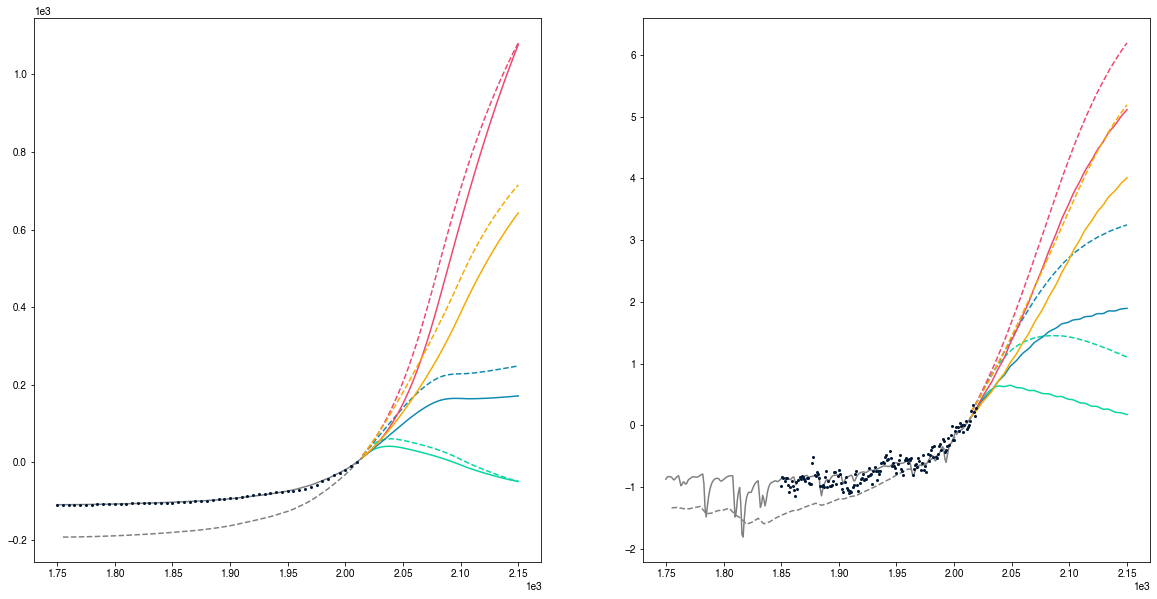

In [16]:
colors= {'ssp245':'#118ab2','ssp370':'#F5AB00','ssp585':'#ef476f','ssp119':'#06d6a0','history':'grey'}

fig,ax = plt.subplots(1,2,figsize=(20,10))

for scenario in scenarios:
    ax[0].plot(GIR_concs.loc[2014:,scenario]-GIR_concs.loc[2005:2014,scenario].mean(),c=colors[scenario])
    ax[1].plot(GIR_temps.loc[2014:,scenario]-GIR_temps.loc[2005:2014,scenario].mean(),c=colors[scenario])
    
    ax[0].plot(DICE_results.loc[2014:,(scenario,'C')]-DICE_results.loc[2005:2015,(scenario,'C')].mean(),c=colors[scenario],ls='--')
    ax[1].plot(DICE_results.loc[2014:,(scenario,'T')]-DICE_results.loc[2005:2014,(scenario,'T')].mean(),c=colors[scenario],ls='--')
    
ax[0].plot(GIR_concs.loc[:2014,scenario]-GIR_concs.loc[2005:2014,scenario].mean(),c=colors['history'])
ax[1].plot(GIR_temps.loc[:2014,scenario]-GIR_temps.loc[2005:2014,scenario].mean(),c=colors['history'])

ax[0].plot(DICE_results.loc[:2014,(scenario,'C')]-DICE_results.loc[2005:2015,(scenario,'C')].mean(),c=colors['history'],ls='--')
ax[1].plot(DICE_results.loc[:2014,(scenario,'T')]-DICE_results.loc[2005:2014,(scenario,'T')].mean(),c=colors['history'],ls='--')

ax[0].plot((WMGHG_concs.loc[1750:,'carbon_dioxide']-WMGHG_concs.loc[2005:2014,'carbon_dioxide'].mean()).iloc[::5],'.',ms=4)
ax[1].plot(np.arange(1850,2020),(GMST_datasets.loc[:'2019']-GMST_datasets.loc['2005':'2014'].mean()).mean(axis=1).resample('y').mean().values,'.',ms=4)

In [ ]:
## You get the same results if initialising from the present day.